# 2. Neural Network Classifier with Keras

Using the multi-label classifier dataset from earlier exercises (categorized-comments.jsonl in the reddit folder), fit a neural network classifier using scikit-learn. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guideline. Report the accuracy, precision, recall, F1-score, and confusion matrix.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import pydot

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score

from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

In [2]:

def load_data(samples=None):
    """A function to load the comments in with the option of selecting a sample size"""
    df = pd.read_json("categorized-comments.jsonl",lines=True)
    if samples != None:
        df = df.sample(round(samples))
    return df


In [3]:
    
def stemmer(ser):
    """Stems each word in a string and returns the string"""
    ps = PorterStemmer()
    string = ""
    for words in ser:
        string += str(ps.stem(words)) + " "
    return string.strip()


def clean_data(df):
    """Cleans the data in preparation for vectorization"""
    df['txt'] = df['txt'].str.lower()
    # Removing \n (new lines)
    df["txt"] = df['txt'].str.replace("\n", " ")

    # Removing URLS
    df['txt'] = df['txt'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df['txt'] = df['txt'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])

    # Removing punctuation
    df["txt"] = df['txt'].str.replace('[^\w\s]','')

    # Creating the list of stop words

    stop = set(stopwords.words('english')) 

    df['txt'] = df['txt'].str.split().apply(lambda x: [item for item in x if item not in stop])
    df['txt'] = df['txt'].apply(stemmer)
    return df


def TfidfVectorization(df):
    """Vectorizes the data for both attributes and targets"""
    cv = TfidfVectorizer()
    cv_features = cv.fit_transform(df['txt'].values.astype('U')).toarray()
    feat_names = cv.get_feature_names()
    cv_targets = cv.fit_transform(df['cat'].values.astype('U')).toarray()
    target_names = cv.get_feature_names()
    return cv_features, cv_targets, feat_names, target_names


In [4]:
# Loading in the data with 60,000 samples
df= load_data(60000)
df

,cat,txt
531862,video_games,U think ur funny?
38509,sports,Was it a bar? I thought it was a group of peop...
456292,video_games,I had to turn it off after 5 seconds. The mus...
106704,sports,Even Henriques recently got 265 in first class...
480719,video_games,consider a spoilers tag
...,...,...
464846,video_games,i would guess because it takes up less room. t...
48414,sports,I honestly can't stand either HC at the Missis...
346268,video_games,"Yeah, probably gonna give TOTY DJ or Marcus Al..."
386188,video_games,Received tracking for Nintendo Power Grip from...


In [5]:
# Cleaning the data
df = clean_data(df)
df

,cat,txt
531862,video_games,u think ur funni
38509,sports,bar thought group peopl outsid nightclub
456292,video_games,turn 5 second music terribl
106704,sports,even henriqu recent got 265 first class right
480719,video_games,consid spoiler tag
...,...,...
464846,video_games,would guess take less room alreadi much shit j...
48414,sports,honestli cant stand either hc mississippi school
346268,video_games,yeah probabl gonna give toti dj marcu allen chanc
386188,video_games,receiv track nintendo power grip best buy pro ...


In [6]:
# Vectorizes the data with the attribute names and target names
X, y, attribute_names, target_names  = TfidfVectorization(df)

In [7]:
# Showing the data in dataframe format
pd.DataFrame(X, columns = attribute_names)

,00,000,0000,00001,0005,001,00101,001101,002,00368,...,ｗｅｖｅ,ｗｈｅｎ,ｗｒｏｎｇ,ｘｍａｓ,ｙｅａｈ,ｙｏｕ,𝓚𝓐𝓡𝓐𝓑𝓐𝓢,𝓚𝓐𝓡𝓐𝓑𝓞𝓢,𝓚𝓐𝓡𝓐𝓚𝓐𝓢,𝓟𝓘𝓓𝓐𝓡𝓐𝓢
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Showing the data in dataframe format
pd.DataFrame(y, columns=target_names)

,science_and_technology,sports,video_games
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
...,...,...,...
59995,0.0,0.0,1.0
59996,0.0,1.0,0.0
59997,0.0,0.0,1.0
59998,0.0,0.0,1.0


In [9]:
# Splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [10]:
# Building a linear stack of layers with the sequential model
model = Sequential()

# Adding dropout to prevent overfitting
model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))

# First hidden layer with 500 output spaces
model.add(Dense(500, activation='relu'))

# More dropout to prevent overfitting
model.add(Dropout(0.2))

# Second hidden layer with 150 output spaces
model.add(Dense(150, activation='softmax'))

# Output layer with 3 output spaces
model.add(Dense(3, activation='softmax'))

# Compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
         ModelCheckpoint(filepath='best_model_cat_comments.h5', monitor='val_loss', save_best_only=True)]

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 34976)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               17488500  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               75150     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 453       
Total params: 17,564,103
Trainable params: 17,564,103
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Training the model
start = datetime.datetime.now()
print("Operation Started: "+str(start.strftime("%m/%d/%y %H:%M:%S")))
history = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs = 200,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))
end = datetime.datetime.now()
print("Operation Ended:"+str(end.strftime("%m/%d/%y %H:%M:%S")))
duration = end-start
print(f"Training Time: {str((duration.seconds // 3600)).zfill(2)}:\
{str((duration.seconds // 60)).zfill(2)}:\
{str((duration.seconds % 60)).zfill(2)}")

Operation Started: 02/20/21 11:09:45
Epoch 1/200
352/352 [==============================] - 80s 221ms/step - loss: 0.9312 - accuracy: 0.7221 - val_loss: 0.6642 - val_accuracy: 0.7157
Epoch 2/200
352/352 [==============================] - 80s 228ms/step - loss: 0.6185 - accuracy: 0.7552 - val_loss: 0.5597 - val_accuracy: 0.8187
Epoch 3/200
352/352 [==============================] - 80s 227ms/step - loss: 0.5182 - accuracy: 0.8421 - val_loss: 0.5008 - val_accuracy: 0.8184
Epoch 4/200
352/352 [==============================] - 79s 223ms/step - loss: 0.4346 - accuracy: 0.8569 - val_loss: 0.4655 - val_accuracy: 0.8298
Epoch 5/200
352/352 [==============================] - 75s 214ms/step - loss: 0.3755 - accuracy: 0.8818 - val_loss: 0.4522 - val_accuracy: 0.8339
Epoch 6/200
352/352 [==============================] - 77s 218ms/step - loss: 0.3374 - accuracy: 0.8888 - val_loss: 0.4404 - val_accuracy: 0.8360
Epoch 7/200
352/352 [==============================] - 74s 211ms/step - loss: 0.3153 - 

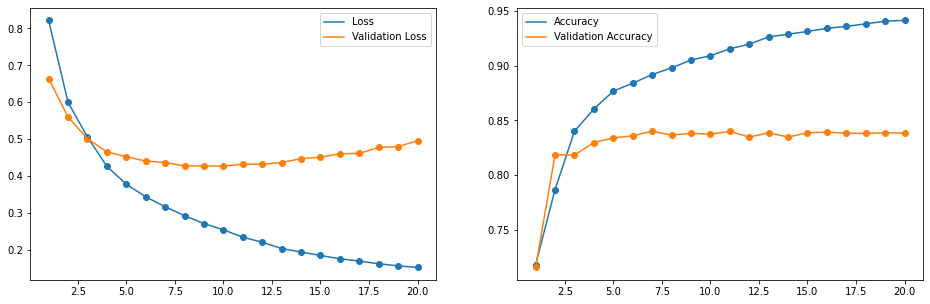

In [12]:
# Plotting the loss and accuracy of the training and testing sets
epochs = len(history.history['loss'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.plot(np.arange(1,epochs+ 1),history.history['loss'], label = 'Loss') 
ax1.plot(np.arange(1,epochs+ 1),history.history['val_loss'], label = 'Validation Loss')
ax1.scatter(np.arange(1,epochs+ 1),history.history['loss']) 
ax1.scatter(np.arange(1,epochs+ 1),history.history['val_loss'])

ax2.plot(np.arange(1,epochs+ 1),history.history['accuracy'], label = 'Accuracy') 
ax2.plot(np.arange(1,epochs+ 1),history.history['val_accuracy'], label = 'Validation Accuracy')

ax2.scatter(np.arange(1,epochs+ 1),history.history['accuracy']) 
ax2.scatter(np.arange(1,epochs+ 1),history.history['val_accuracy'])

ax1.legend()
ax2.legend()
plt.show()

In [13]:
# Predicting the classes of the testing set
y_pred = model.predict(X_test).round()
y_pred

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [14]:
# Accuracy, recall, and precision
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average='macro')*100:.2f}%")

Accuracy: 83.59%
Precision: 80.92%
Recall: 65.79%


In [15]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

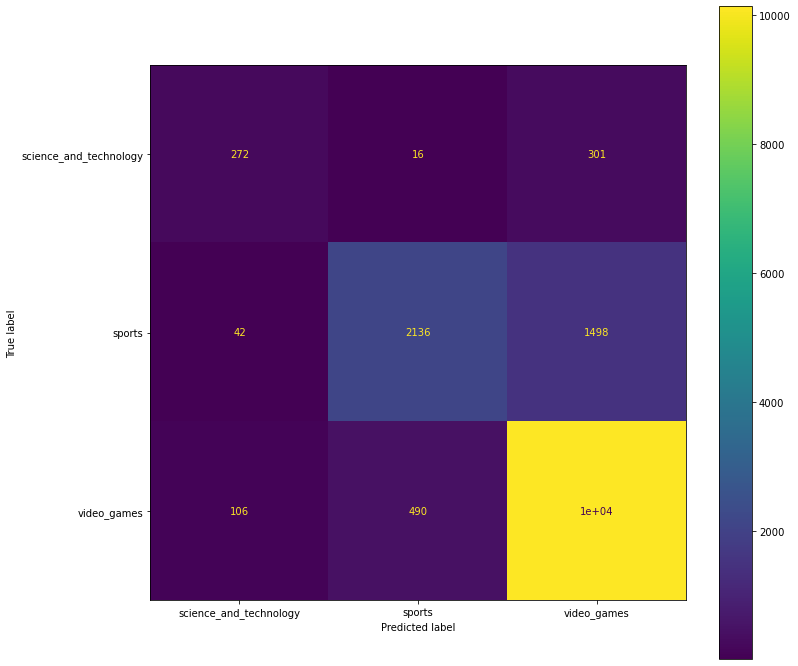

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
fig = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names)
fig.plot(ax=ax)
plt.show()